In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
x_train, x_val = x_train/255, x_val/255

Import pre-trained model:

In [ ]:
vgg_model = keras.applications.vgg16.VGG16(weights='imagenet',
include_top=False, input_shape=(32,32,3) )


vgg_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

Create seqential model and copy layers from the imported pre-trained model:

In [ ]:
# model = keras.models.Sequential()
# for layer in vgg_model.layers[0:-5]:
#   model.add(layer)

# model.summary()

With data augmentation:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.RandomRotation(0.2, input_shape=(32,32,3)))
# model.add(keras.layers.RandomFlip()
for layer in vgg_model.layers[1:-5]:
  model.add(layer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                        

Freeze layers (without fine-tuning):

In [ ]:
# for layer in model.layers:
#   layer.trainable = False

# model.summary()

Fine tuning:

In [ ]:
for layer in model.layers[:-2]:
  layer.trainable = False

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                        

Add classification layers:

In [ ]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2, l1

reg_rate = 1e-3

model.add(Flatten())
BatchNormalization()
model.add(Dense(1024, activation = 'relu', kernel_regularizer=l2(reg_rate)))
Dropout(0.5)
BatchNormalization()
model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(reg_rate)))
Dropout(0.5)
BatchNormalization()
model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(reg_rate)))
Dropout(0.5)

model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                        

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy()
# optimizer = keras.optimizers.Adam(.001)
optimizer = keras.optimizers.SGD(learning_rate=.001,momentum=.9)
metrics = ['accuracy']

model.compile(optimizer, loss, metrics)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.1, #Factor by which learning rate will be reduced
                       patience=2,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-6) #The minimum learning rate

from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy',
                          patience=3)

In [ ]:
batch_size = 32
epochs = 30

history = model.fit(x_train, y_train, batch_size, epochs,
          validation_data = (x_val, y_val), callbacks=[lrr,earlyStop])

Epoch 1/30
1563/1563 [==============================] - 36s 18ms/step - loss: 3.3463 - accuracy: 0.6747 - val_loss: 3.1051 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 26s 17ms/step - loss: 2.8965 - accuracy: 0.7801 - val_loss: 2.9054 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - 26s 16ms/step - loss: 2.6117 - accuracy: 0.8356 - val_loss: 2.7310 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - 25s 16ms/step - loss: 2.3655 - accuracy: 0.8792 - val_loss: 2.6296 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 5/30
1563/1563 [==============================] - 25s 16ms/step - loss: 2.1454 - accuracy: 0.9175 - val_loss: 2.5993 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 6/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.9600 - accuracy: 0.9467 - val_loss: 2.5676 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 7/30
1563/1563 [========================

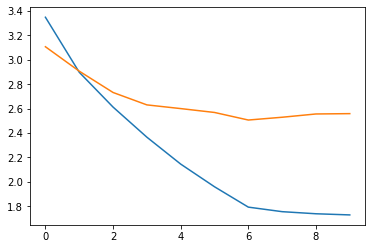

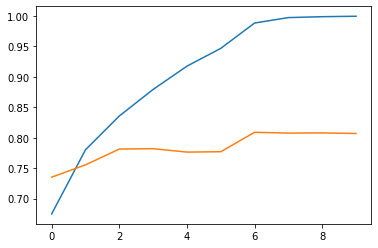

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)

plt.figure()

plt.plot(accuracy)
plt.plot(val_accuracy)